In [2]:
import torch
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Individual parameters

In [206]:
# generation of the individual parameters

n_patients = 600

# individual_parameters
xi_mean = 0
sigma_xi = 0.5
tau_mean = 70
sigma_tau = 15
sources_std = 1

columns = ['xi', 'tau', 'source']
feature_parameters = pd.DataFrame(columns=columns)

for i in range(n_patients):
    xi = np.random.normal(xi_mean, sigma_xi)
    tau = np.random.normal(tau_mean, sigma_tau)
    source = np.random.normal(0,sources_std)
    feature_parameters.loc[i] = [xi, tau, source]
    
feature_parameters.head()

,xi,tau,source
0,1.014325,62.774652,0.754972
1,-0.013000,67.088278,1.354144
2,0.309078,78.829035,1.221850
3,-0.828309,51.065564,-0.960321
4,0.193659,84.696859,-0.210169


In [196]:
feature_parameters.describe().drop('count')

,xi,tau,source
mean,0.012328,71.685638,-0.069372
std,0.499577,15.733838,1.049221
min,-1.582989,15.906035,-2.990307
25%,-0.309179,61.446445,-0.801843
50%,0.048985,72.176869,-0.060101
75%,0.339336,82.368926,0.708471
max,1.202224,116.844587,3.017679


# Simulation with closed form geodesics

In [99]:
# logistic sampler from individidual parameters

def logistic(timepoints, acceleration, timeshift, a=0, b=1, spaceshift=None, noise=None):
    """
    - timepoints : real ages of patients at which we want the visits
    - acceleration : feature wise acceleration factor
    - timeshift : feature wise timeshift (point at which the logistic curves hits a fixed value across features)
    - a,b : first asymptote and second asymptote. By default features go from 0 to 1
    """
    L = np.exp(acceleration)/14*(timepoints - timeshift)
    if noise is not None:
        L = L+noise
    if spaceshift is not None:
        return a + (b-a)/(1+np.exp(-L + spaceshift/20)) 
    return a + (b-a)/(1+np.exp(-L))

def sum_logistic(timepoints, acceleration, timeshift, a=0, b=1, spaceshift=None):
    """
    - timepoints : real ages of patients at which we want the visits
    - acceleration : feature wise acceleration factor
    - timeshift : feature wise timeshift (point at which the logistic curves hits a fixed value across features)
    - a,b : first asymptote and second asymptote. By default features go from 0 to 1
    """
    Lp = np.exp(acceleration)/3*(np.array(timepoints) - np.array(timeshift)) + 4
    Lm = np.exp(acceleration)/3*(np.array(timepoints) - np.array(timeshift)) - 4
    if spaceshift is not None:
        return a + (b-a)/(1+np.exp(-Lp + spaceshift/3))/2 + (b-a)/(1+np.exp(-Lm + spaceshift/3))/2
    return  a + (b-a)/(1+np.exp(-Lp))/2 + (b-a)/(1+np.exp(-Lm))/2

def linear(timepoints, acceleration, timeshift, a=0, b=1, spaceshift=None):
    """
    - timepoints : real ages of patients at which we want the visits
    - acceleration : feature wise acceleration factor
    - timeshift : feature wise timeshift (point at which the logistic curves hits a fixed value across features)
    - a,b : first 'asymptote' and second 'asymptote'. By default features go from 0 to 1
    """
    m = (b-a)/80
    if spaceshift is not None:
        return a + (b-a)/2 + m*np.exp(acceleration)*(timepoints-timeshift) + m*spaceshift
    return a + (b-a)/2 + m*np.exp(acceleration)*(timepoints-timeshift)

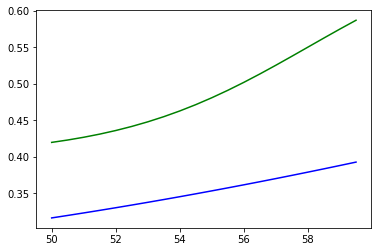

In [175]:
t = np.arange(60,60,0.5)
p1 = logistic(t, 0, 70, 0.2, 0.8, spaceshift=0)
p2 = sum_logistic(t, 0, 70, 0.4, 1, spaceshift=0) 

plt.plot(t,p1,c='b')
plt.plot(t,p2,c='g')

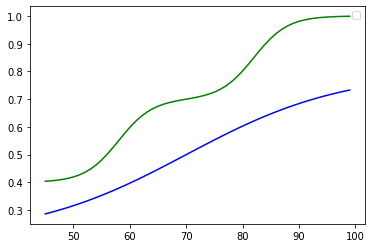

In [177]:
t = np.arange(45,100,1)

#t = np.array([60,60.5,51,52,53])
p1 = logistic(t, 0.0, 70, 0.2, 0.8, spaceshift=0)
p2 = sum_logistic(t, 0, 70, 0.4, 1, spaceshift=0) 
p3 = linear(t, 0, 70, 0.4, 0.9, spaceshift=0)
p1_source_neg = logistic(t, 0, 70, 0.2, 0.8, 8)
p2_source_neg = sum_logistic(t, 0, 70, 0.3, 1, -8) 
p3_source_neg = linear(t, 0, 70, 0.4, 0.9, -8)
p1_source_pos = logistic(t, 0, 70, 0.2, 0.8, -8)
p2_source_pos = sum_logistic(t, 0, 70, 0.3, 1, 8) 
p3_source_pos = linear(t, 0, 70, 0.4, 0.9, 8)

plt.plot(t,p1,c='b')
plt.plot(t,p2,c='g')

"""
plt.plot(t,p3,c='r')
plt.plot(t,p1_source_pos)
plt.plot(t,p1_source_neg)
plt.plot(t,p3_source_pos)
plt.plot(t,p3_source_neg)
"""
plt.legend()
plt.show()


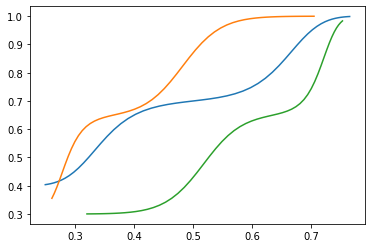

In [80]:
plt.plot(p1,p2)
plt.plot(p1_source_neg,p2_source_neg)
plt.plot(p1_source_pos,p2_source_pos)

In [81]:
# generate the associated trajectories 

visits_per_patients = 8
time_between_visits = 0.5
columns = ['feat1', 'feat2']

noise_std = 0.02

data = []
for sub in feature_parameters.index:
    id_params = feature_parameters.loc[sub]
    time_first_visit = np.random.normal(loc=70, scale=15)
    timepoints = [time_first_visit + i*time_between_visits for i in range(visits_per_patients)]
    feature_1 = logistic(np.array(timepoints), id_params[0], id_params[1], a=0.2, b=0.8, spaceshift=-id_params[2]/2) + np.random.normal(0, noise_std, visits_per_patients)
    feature_2 = sum_logistic(np.array(timepoints), id_params[0], id_params[1], a=0.4, b=1, spaceshift=id_params[2]/2)+ np.random.normal(0, noise_std, visits_per_patients)
    #feature_2 = linear(np.array(timepoints), id_params[0], id_params[1], a=0.4, b=0.9, spaceshift=id_params[2]/2)+ np.random.normal(0, noise_std, visits_per_patients)

    sub_data = pd.DataFrame([timepoints,feature_1, feature_2]).T
    sub_data.columns = ['TIME', 'feat1', 'feat2']
    sub_data['ID'] = sub
    sub_data = sub_data.set_index(['ID'])
    
    data.append(sub_data)
    
data = pd.concat(data)

In [93]:
# Histogram of reparametrized ages

ages = []
for sub in data.index.unique():
    ip = feature_parameters.loc[sub]
    timepoints = data.loc[sub]['TIME']
    ages += list((np.exp(ip['xi'])*(timepoints - ip['tau']) + 70).values)
    

(array([  9.,   6.,   1.,   0.,   2.,   6.,   1.,  21.,  15.,  14.,  18.,
         16.,  33., 127., 198., 269., 421., 294., 275., 207.,  95.,  93.,
         87.,  59.,  24.,  28.,  17.,   9.,   7.,   8.,   8.,   7.,   9.,
          0.,   0.,   0.,   2.,   3.,   6.,   5.]),
 array([-36.73688441, -30.47813656, -24.21938872, -17.96064088,
        -11.70189303,  -5.44314519,   0.81560265,   7.0743505 ,
         13.33309834,  19.59184618,  25.85059403,  32.10934187,
         38.36808972,  44.62683756,  50.8855854 ,  57.14433325,
         63.40308109,  69.66182893,  75.92057678,  82.17932462,
         88.43807246,  94.69682031, 100.95556815, 107.21431599,
        113.47306384, 119.73181168, 125.99055952, 132.24930737,
        138.50805521, 144.76680305, 151.0255509 , 157.28429874,
        163.54304658, 169.80179443, 176.06054227, 182.31929012,
        188.57803796, 194.8367858 , 201.09553365, 207.35428149,
        213.61302933]),
 <BarContainer object of 40 artists>)

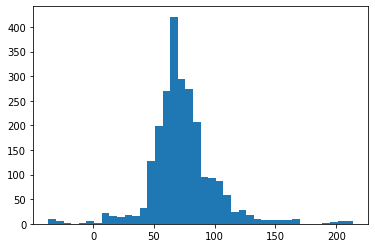

In [94]:
plt.hist(ages, bins=40)

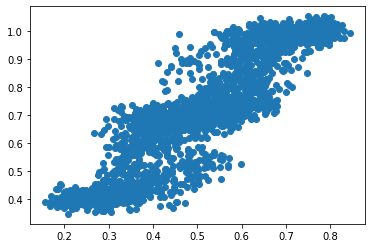

In [84]:
plt.scatter(data['feat1'], data['feat2'])

In [85]:
data.describe(percentiles=[.1,.2,.8,.95])

,TIME,feat1,feat2
count,2400.000000,2400.000000,2400.000000
mean,71.622128,0.503631,0.705540
std,14.691094,0.158287,0.202470
min,26.827043,0.156848,0.345650
10%,53.531614,0.290544,0.410878
20%,59.697214,0.351715,0.470513
50%,71.540375,0.506211,0.701785
80%,83.848045,0.652532,0.951923
95%,95.291359,0.764270,1.007501
max,113.860622,0.843217,1.053964


In [86]:
data

,TIME,feat1,feat2
ID,,,
0,55.764067,0.423630,0.464063
0,56.264067,0.440336,0.495255
0,56.764067,0.447971,0.458690
0,57.264067,0.494731,0.481166
0,57.764067,0.502920,0.452465
...,...,...,...
299,67.810785,0.587139,0.691150
299,68.310785,0.549751,0.697607
299,68.810785,0.570529,0.693200


In [87]:
data_path = 'simulated_study/simulated_data_1/'
data.to_csv(data_path + 'simulated_data_test.csv')
feature_parameters.to_csv(data_path + 'true_individual_parameters.csv')

## Save the data 

In [88]:
X = data['TIME'].values
Y = data[['feat1', 'feat2']].values
group = [int(sub) for sub in data.index.values]

In [89]:
np.savetxt(data_path + 'X.csv', X)
np.savetxt(data_path + 'Y.csv', Y, delimiter=',')
np.savetxt(data_path + 'group.csv', group)

In [90]:
data.describe(percentiles=[.1,.2,.3,.5,.7,.8,.9, .95])

,TIME,feat1,feat2
count,2400.000000,2400.000000,2400.000000
mean,71.622128,0.503631,0.705540
std,14.691094,0.158287,0.202470
min,26.827043,0.156848,0.345650
10%,53.531614,0.290544,0.410878
20%,59.697214,0.351715,0.470513
30%,63.857023,0.407462,0.606109
50%,71.540375,0.506211,0.701785
70%,79.079878,0.599564,0.809901
80%,83.848045,0.652532,0.951923


# Simulating with a metric

In [207]:
import numpy as np
import pandas as pd
import torch
import sys
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append('/home/benoit.sautydechalon/deformetrica')

from deformetrica.core.estimator_tools.samplers.srw_mhwg_sampler import SrwMhwgSampler
from deformetrica.core.estimators.gradient_ascent import GradientAscent
from deformetrica.core.estimators.mcmc_saem import McmcSaem
# Estimators
from deformetrica.core.estimators.scipy_optimize import ScipyOptimize
from deformetrica.core.model_tools.manifolds.exponential_factory import ExponentialFactory
from deformetrica.core.model_tools.manifolds.generic_spatiotemporal_reference_frame import GenericSpatiotemporalReferenceFrame
from deformetrica.core.models.longitudinal_metric_learning import LongitudinalMetricLearning
from deformetrica.core.models.model_functions import create_regular_grid_of_points
from deformetrica.in_out.array_readers_and_writers import read_2D_array
from deformetrica.in_out.dataset_functions import read_and_create_scalar_dataset, read_and_create_image_dataset
from deformetrica.support.probability_distributions.multi_scalar_normal_distribution import MultiScalarNormalDistribution
from deformetrica.support.utilities.general_settings import Settings
from deformetrica import estimate_longitudinal_metric_model
from deformetrica.in_out.array_readers_and_writers import *
from deformetrica.launch.estimate_longitudinal_metric_model import instantiate_longitudinal_metric_model
import deformetrica as dfca

In [208]:
path = 'simulated_study'
args = {'verbosity':'INFO', 'output':'personalize',
        'model':path+'/model_1.xml', 'dataset':path+'/data_set.xml', 'parameters':path+'/optimization_parameters_saem.xml'}


"""
Read xml files, set general settings, and call the adapted function.
"""

xml_parameters = dfca.io.XmlParameters()
xml_parameters.read_all_xmls(args['model'],
                             args['dataset'],
                             args['parameters'])

logger = logging.getLogger(__name__)
logging.getLogger('matplotlib').setLevel(logging.ERROR)
logger.setLevel(logging.INFO)

In [209]:
dataset = read_and_create_scalar_dataset(xml_parameters)
model, individual_RER = instantiate_longitudinal_metric_model(xml_parameters, logger, dataset, observation_type='scalar')

152 good iterations out of 153
191 good iterations out of 209


In [210]:
onset_ages = torch.tensor(feature_parameters['tau'])
log_accelerations = torch.tensor(feature_parameters['xi'])
sources = torch.tensor([[float(source)] for source in feature_parameters['source'].values])

In [211]:
# Timepoints of visits

visits_per_patients = 14
time_between_visits = 0.4

noise_std = 0.02

timepoints_lst = []
timepoints = []

for sub in feature_parameters.index:
    time_first_visit = np.random.normal(loc=70, scale=15)
    timepoints_lst = timepoints_lst + [time_first_visit + i*time_between_visits for i in range(visits_per_patients)]
    timepoints.append([time_first_visit + i*time_between_visits for i in range(visits_per_patients)])

In [212]:
v0, p0, metric_parameters, modulation_matrix = model._fixed_effects_to_torch_tensors(False)
#onset_ages, log_accelerations, sources = model._individual_RER_to_torch_tensors(individual_RER, False)
t0 = model.get_reference_time()

absolute_times = model._compute_absolute_times(np.array(timepoints), log_accelerations, onset_ages)

absolute_times_to_write = []
for elt in absolute_times:
    for e in elt.cpu().data.numpy():
        absolute_times_to_write.append(e)

#np.savetxt(os.path.join(Settings().output_dir, "LongitudinalMetricModel_absolute_times.txt"), np.array(absolute_times_to_write))

model._update_spatiotemporal_reference_frame(absolute_times, p0, v0, metric_parameters,
                                            modulation_matrix)

Patient  102  was estimated with an absurd timeshift tensor(177.6139)
Patient  256  was estimated with an absurd timeshift tensor(174.6994)
152 good iterations out of 153
191 good iterations out of 209


In [213]:
predictions = []
subject_ids = []
times = []

targets = dataset.deformable_objects

number_of_subjects = dataset.number_of_subjects
residuals = []

for i in range(len(absolute_times)):
    predictions_i = []
    for j, t in enumerate(absolute_times[i]):
        if sources is not None:
            prediction = model.spatiotemporal_reference_frame.get_position(t, sources=sources[i])
        else:
            prediction = model.spatiotemporal_reference_frame.get_position(t)
        predictions_i.append(prediction.cpu().data.numpy())
        predictions.append(prediction.cpu().data.numpy())
        subject_ids.append(i)
        times.append(absolute_times[i][j])


In [214]:
feat_1 = [prediction[0] for prediction in predictions]
feat_2 = [prediction[1] for prediction in predictions]

In [216]:
data_path = 'simulated_study/simulated_data_metric_1/'
feature_parameters.to_csv(data_path + 'true_individual_parameters.csv')

## Save the data 

In [217]:
X = np.array(timepoints_lst)
Y = predictions
group = []
for i in range(len(absolute_times)):
    group = group + [i for j in range(14)]

In [218]:
np.savetxt(data_path + 'X.csv', X)
np.savetxt(data_path + 'Y.csv', Y, delimiter=',')
np.savetxt(data_path + 'group.csv', group)

## Add the noise

In [219]:
data_path = 'simulated_study/simulated_data_metric_1/'

In [220]:
data = pd.read_csv(data_path + 'Y.csv', header=None)

In [221]:
noise_std = 0.02

data_noisy = data + np.random.normal(0, noise_std, data.shape)

In [222]:
data_path = 'simulated_study/simulated_data_metric_1/'
np.savetxt(data_path + 'Y.csv', data_noisy.values, delimiter=',')

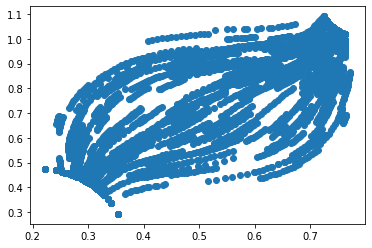

In [224]:
plt.scatter(data[0], data[1])


## Figures to compare geodesics and different approaches

### Fixed product metric

In [171]:
timepoints_fixed = np.arange(20,125,0.5)

spaceshifts = [-10,-5,-2,0,2,5,10]
feat_1_fixed = [logistic(timepoints_fixed, -.4, 60, spaceshift=-w) for w in spaceshifts]
feat_2_fixed = [logistic(timepoints_fixed, -.4, 80, spaceshift=w) for w in spaceshifts]

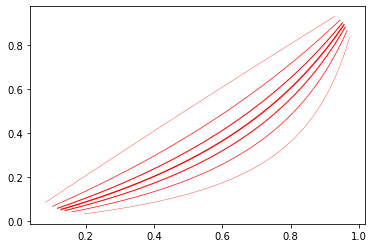

In [172]:
for i in range(len(spaceshifts)):
    plt.plot(feat_1_fixed[i], feat_2_fixed[i], color='r', linewidth=(4-abs(i-3))/3)
plt.show()

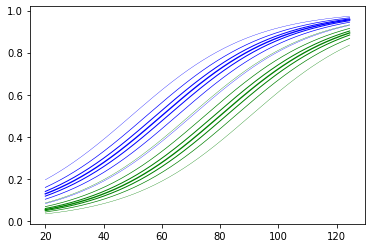

In [173]:
for i in range(7):
    plt.plot(timepoints_fixed, feat_1_fixed[i], color='b', linewidth=(4-abs(i-3))/3)
    plt.plot(timepoints_fixed, feat_2_fixed[i], color='g', linewidth=(4-abs(i-3))/3)
plt.show()

### Learned metric

In [104]:
import numpy as np
import pandas as pd
import torch
import sys
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append('/home/benoit.sautydechalon/deformetrica')

from deformetrica.core.estimator_tools.samplers.srw_mhwg_sampler import SrwMhwgSampler
from deformetrica.core.estimators.gradient_ascent import GradientAscent
from deformetrica.core.estimators.mcmc_saem import McmcSaem
# Estimators
from deformetrica.core.estimators.scipy_optimize import ScipyOptimize
from deformetrica.core.model_tools.manifolds.exponential_factory import ExponentialFactory
from deformetrica.core.model_tools.manifolds.generic_spatiotemporal_reference_frame import GenericSpatiotemporalReferenceFrame
from deformetrica.core.models.longitudinal_metric_learning import LongitudinalMetricLearning
from deformetrica.core.models.model_functions import create_regular_grid_of_points
from deformetrica.in_out.array_readers_and_writers import read_2D_array
from deformetrica.in_out.dataset_functions import read_and_create_scalar_dataset, read_and_create_image_dataset
from deformetrica.support.probability_distributions.multi_scalar_normal_distribution import MultiScalarNormalDistribution
from deformetrica.support.utilities.general_settings import Settings
from deformetrica import estimate_longitudinal_metric_model
from deformetrica.in_out.array_readers_and_writers import *
from deformetrica.launch.estimate_longitudinal_metric_model import instantiate_longitudinal_metric_model
import deformetrica as dfca

In [15]:
path = 'simulated_study'
args = {'verbosity':'INFO', 'output':'personalize',
        'model':path+'/model_1.xml', 'dataset':path+'/data_set.xml', 'parameters':path+'/optimization_parameters_saem.xml'}


"""
Read xml files, set general settings, and call the adapted function.
"""

xml_parameters = dfca.io.XmlParameters()
xml_parameters.read_all_xmls(args['model'],
                             args['dataset'],
                             args['parameters'])

logger = logging.getLogger(__name__)
logging.getLogger('matplotlib').setLevel(logging.ERROR)
logger.setLevel(logging.INFO)

In [16]:
dataset = read_and_create_scalar_dataset(xml_parameters)
model, individual_RER = instantiate_longitudinal_metric_model(xml_parameters, logger, dataset, observation_type='scalar')

In [17]:
spaceshifts = [-.8, -.5, -.2, 0, .2, .5, .8]

onset_ages = torch.tensor([76 for i in range(len(spaceshifts))])
log_accelerations = torch.tensor([0 for i in range(len(spaceshifts))])
sources = torch.tensor([[float(source)] for source in spaceshifts])

In [18]:
# Timepoints of visits

timepoints = [np.arange(60,100, 0.5) for i in range(len(onset_ages))]

In [19]:
v0, p0, metric_parameters, modulation_matrix = model._fixed_effects_to_torch_tensors(False)
#onset_ages, log_accelerations, sources = model._individual_RER_to_torch_tensors(individual_RER, False)
t0 = model.get_reference_time()

absolute_times = model._compute_absolute_times(np.array(timepoints), log_accelerations, onset_ages)

absolute_times_to_write = []
for elt in absolute_times:
    for e in elt.cpu().data.numpy():
        absolute_times_to_write.append(e)

#np.savetxt(os.path.join(Settings().output_dir, "LongitudinalMetricModel_absolute_times.txt"), np.array(absolute_times_to_write))

model._update_spatiotemporal_reference_frame(absolute_times, p0, v0, metric_parameters,
                                            modulation_matrix)

In [20]:
predictions = []
subject_ids = []
times = []

for i in range(len(absolute_times)):
    predictions_i = []
    for j, t in enumerate(absolute_times[i]):
        prediction = model.spatiotemporal_reference_frame.get_position(t, sources=sources[i])
        predictions_i.append(prediction.cpu().data.numpy())
        subject_ids.append(i)
        times.append(absolute_times[i][j])
    predictions.append(predictions_i)

In [21]:
feat_1 = [[prediction[0] for prediction in predictions[i]] for i in range(len(predictions))]
feat_2 = [[prediction[1] for prediction in predictions[i]] for i in range(len(predictions))]

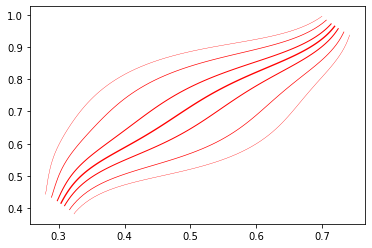

In [22]:
for i in range(len(spaceshifts)):
    plt.plot(feat_1[i], feat_2[i], color='r', linewidth=(4-abs(i-3))/3)
plt.show()

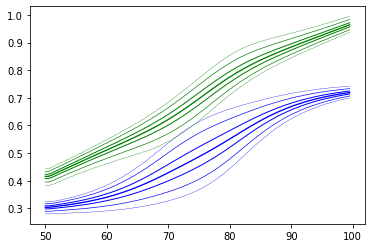

In [23]:
for i in range(7):
    plt.plot(timepoints[0], feat_1[i], color='b', linewidth=(4-abs(i-3))/3)
    plt.plot(timepoints[0], feat_2[i], color='g', linewidth=(4-abs(i-3))/3)
plt.show()

In [77]:
times = [time[0] for time in pd.read_csv(path+'/simulated_data_1/X.csv', header=None).values]
logistic = [score[0] for score in pd.read_csv(path+'/simulated_data_1/Y.csv', header=None).values]
sum_logistic = [score[1] for score in pd.read_csv(path+'/simulated_data_1/Y.csv', header=None).values]
ids = [int(idx[0]) for idx in pd.read_csv(path+'/output_1/LongitudinalMetricModel_subject_ids.txt', header=None).values]

In [78]:
data = pd.DataFrame(index=[ids, times], columns=['logistic', 'sum_logistic'])
data['logistic'] = logistic
data['sum_logistic'] = sum_logistic
data

logistic  sum_logistic
0   74.514828  0.542231      0.697105
    75.014828  0.587055      0.704309
    75.514828  0.610650      0.721506
    76.014828  0.596092      0.649232
    76.514828  0.619504      0.739787
...                 ...           ...
499 32.717083  0.194828      0.376004
    33.217083  0.198962      0.415851
    33.717083  0.254344      0.402618
    34.217083  0.222692      0.396403
    34.717083  0.243077      0.422633

[5000 rows x 2 columns]

### Putting the plots together

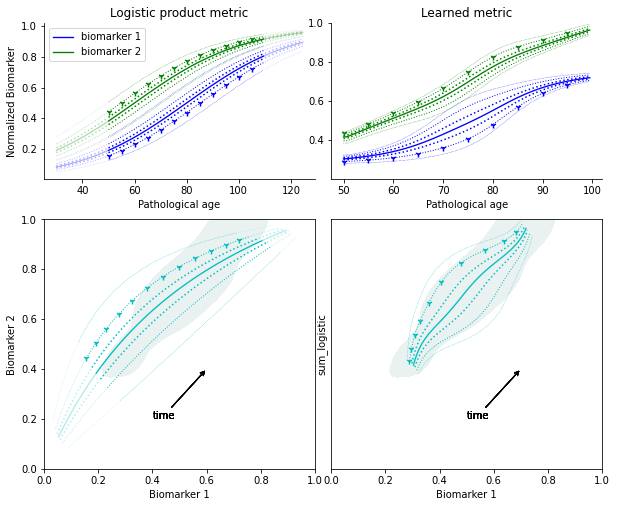

In [183]:
fig, axes = plt.subplots(2,2, figsize=(10,8.2), gridspec_kw={'wspace':0.06, 'height_ratios': [1, 1.6]})

linestyle = ['dashed', 'dotted']
for i in range(7):
    if i == 5:
        axes[0][0].scatter(timepoints_fixed[60:180:10], feat_1_fixed[i][60:180:10], color='g', marker='1')
        axes[0][0].scatter(timepoints_fixed[60:180:10], feat_2_fixed[i][60:180:10], color='b', marker='1')
        axes[0][1].scatter(timepoints[0][::10], feat_1[i][::10], color='b', marker='1')
        axes[0][1].scatter(timepoints[0][::10], feat_2[i][::10], color='g', marker='1')
        axes[1][0].scatter(feat_2_fixed[i][60:180:10], feat_1_fixed[i][60:180:10], color='c', marker='1')
        axes[1][1].scatter(feat_1[i][::10], feat_2[i][::10], color='c', marker='1')
    if i == 3:
        axes[0][0].plot(timepoints_fixed[60:180], feat_2_fixed[i][60:180], color='b', linewidth=(4-abs(i-3))/3, label='biomarker 1')
        axes[0][0].plot(timepoints_fixed[20:60], feat_2_fixed[i][20:60], color='b', linewidth=(4-abs(i-3))/3, alpha=.3)
        axes[0][0].plot(timepoints_fixed[180:], feat_2_fixed[i][180:], color='b', linewidth=(4-abs(i-3))/3, alpha=.3)
        axes[0][0].plot(timepoints_fixed[60:180], feat_1_fixed[i][60:180], color='g', linewidth=(4-abs(i-3))/3, label='biomarker 2')
        axes[0][0].plot(timepoints_fixed[20:60], feat_1_fixed[i][20:60], color='g', linewidth=(4-abs(i-3))/3, alpha=.3)
        axes[0][0].plot(timepoints_fixed[180:], feat_1_fixed[i][180:], color='g', linewidth=(4-abs(i-3))/3, alpha=.3)
        axes[0][1].plot(timepoints[0], feat_1[i], color='b', linewidth=(4-abs(i-3))/3)
        axes[0][1].plot(timepoints[0], feat_2[i], color='g', linewidth=(4-abs(i-3))/3)
        axes[1][0].plot(feat_2_fixed[i][60:180], feat_1_fixed[i][60:180], color='c', linewidth=(4-abs(i-3))/3)
        axes[1][0].plot(feat_2_fixed[i][:60], feat_1_fixed[i][:60], color='c', linewidth=(4-abs(i-3))/3, alpha=.3)
        axes[1][0].plot(feat_2_fixed[i][180:], feat_1_fixed[i][180:], color='c', linewidth=(4-abs(i-3))/3, alpha=.3)
        axes[1][1].plot(feat_1[i], feat_2[i], color='c', linewidth=(4-abs(i-3))/3)
    else:
        axes[0][0].plot(timepoints_fixed[60:180], feat_2_fixed[i][60:180], color='b', linewidth=(4-abs(i-3))/2, linestyle='dotted')
        axes[0][0].plot(timepoints_fixed[20:60], feat_2_fixed[i][20:60], color='b', linewidth=(4-abs(i-3))/2, linestyle='dotted', alpha=.3)
        axes[0][0].plot(timepoints_fixed[180:], feat_2_fixed[i][180:], color='b', linewidth=(4-abs(i-3))/2, linestyle='dotted', alpha=.3)
        axes[0][0].plot(timepoints_fixed[60:180], feat_1_fixed[i][60:180], color='g', linewidth=(4-abs(i-3))/2, linestyle='dotted')
        axes[0][0].plot(timepoints_fixed[20:60], feat_1_fixed[i][20:60], color='g', linewidth=(4-abs(i-3))/2, linestyle='dotted', alpha=.3)
        axes[0][0].plot(timepoints_fixed[180:], feat_1_fixed[i][180:], color='g', linewidth=(4-abs(i-3))/2, linestyle='dotted', alpha=.3)
        axes[0][1].plot(timepoints[0], feat_1[i], color='b', linewidth=(4-abs(i-3))/2, linestyle='dotted')
        axes[0][1].plot(timepoints[0], feat_2[i], color='g', linewidth=(4-abs(i-3))/2, linestyle='dotted')
        axes[1][0].plot(feat_2_fixed[i][60:180], feat_1_fixed[i][60:180], color='c', linewidth=(4-abs(i-3))/2, linestyle='dotted')
        axes[1][0].plot(feat_2_fixed[i][:60], feat_1_fixed[i][:60], color='c', linewidth=(4-abs(i-3))/2, linestyle='dotted', alpha=.3)
        axes[1][0].plot(feat_2_fixed[i][180:], feat_1_fixed[i][180:], color='c', linewidth=(4-abs(i-3))/2, linestyle='dotted', alpha=.3)


        axes[1][1].plot(feat_1[i], feat_2[i], color='c', linewidth=(4-abs(i-3))/2, linestyle='dotted')
    
    #data += np.random.normal(0, .02, data.shape)
    sns.kdeplot(data=data, x='logistic', y='sum_logistic', fill=True, alpha=0.01, color='c', levels=[0.4,1], ax=axes[1][1])
    sns.kdeplot(data=data, x='logistic', y='sum_logistic', fill=True, alpha=0.01, color='c', levels=[0.4,1], ax=axes[1][0])

    axes[0][0].set_title('Logistic product metric')
    axes[0][1].set_title('Learned metric')
    axes[0][0].set_xlabel('Pathological age')
    axes[0][1].set_xlabel('Pathological age')
    
    axes[1][0].set_xlabel('Biomarker 1')
    axes[1][1].set_xlabel('Biomarker 1')
    axes[1][0].set_ylabel('Biomarker 2')

    axes[0][0].legend()

    axes[0][0].spines['right'].set_visible(False)
    axes[0][0].spines['top'].set_visible(False)   
    axes[0][1].spines['right'].set_visible(False)
    axes[0][1].spines['top'].set_visible(False)   
    
    axes[0][1].set_yticks([.4,.6,.8,1])
    axes[1][1].set_yticks([])
    
    axes[0][1].set_ylim([.2,1])

    axes[1][0].set_ylim([0,1])
    axes[1][1].set_ylim([0,1])
    axes[1][0].set_xlim([0,1])
    axes[1][1].set_xlim([0,1])
    
    axes[0][0].set_ylabel('Normalized Biomarker')
    
    axes[1][0].annotate("time", style="normal",
            xy=(0.6, 0.4),
            xytext=(0.4, 0.2), 
            arrowprops=dict(arrowstyle="->", connectionstyle='arc3'))
    axes[1][1].annotate("time",
            xy=(0.7, 0.4),
            xytext=(0.5, 0.2), 
            arrowprops=dict(arrowstyle="->", connectionstyle='arc'))


plt.savefig('illustration.png', dpi=600, bbox_inches='tight')
plt.show()